# WASP-80b: Generation of the master bias and flatfield frames

Hannu Parviainen, Alice Booth, Mantas Abazorius                                                                                                
hannu.parviainen@physics.ox.ac.uk

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
from scipy.ndimage import gaussian_filter1d as gf
from scipy.ndimage import median_filter as mf
from scipy.stats import scoreatpercentile as sap
from src.core import *

## Create the master bias

Bias is constant along the y-axis but shows a small slope in the x-direction. We account for this slope by calculating a 1D bias profile.

In [86]:
bkeys = 'n1ccd1 n1ccd2 n2ccd1 n2ccd2'.split()

In [27]:
biases = dict(n1ccd1 = dstack([pf.getdata(bias,1) for bias in l_bias[0]]),
              n1ccd2 = dstack([pf.getdata(bias,2) for bias in l_bias[0]]),
              n2ccd1 = dstack([pf.getdata(bias,1) for bias in l_bias[1]]),
              n2ccd2 = dstack([pf.getdata(bias,2) for bias in l_bias[1]]))

In [33]:
bias_medians = {k:median(v,2) for k,v in biases.iteritems()}

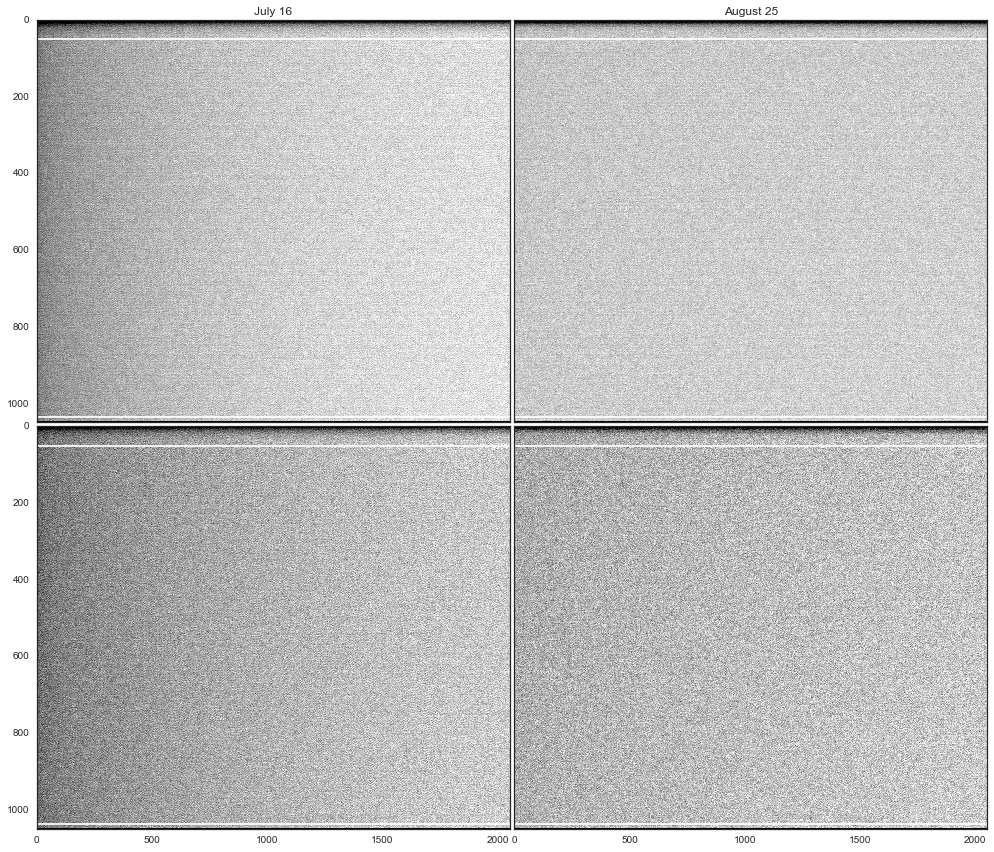

In [87]:
fig,ax = subplots(2,2,figsize=(14,12), sharex=True, sharey=True)
iargs = dict(cmap=cm.gray, interpolation='nearest', aspect='auto')
for i,k in enumerate(bkeys):
    a = bias_medians[k].T
    ax.flat[i].imshow(a, vmin=sap(a,1), vmax=sap(a,99), **iargs)
ax[0,0].set_title('July 16')
ax[0,1].set_title('August 25')
[a.axhline(bias_window[1].start, c='w') for a in ax.flat]
[a.axhline(bias_window[1].stop, c='w') for a in ax.flat]
fig.tight_layout()
fig.subplots_adjust(wspace=0.01, hspace=0.01)

In [140]:
b1d_raw = {k:pd.Series(b[bias_window].mean(1), name=k+'_raw') for k,b in bias_medians.iteritems()}
b1d_denoised = {k:pd.Series(gf(v,20), name=k+'_denoised') for k,v in b1d_raw.items()}

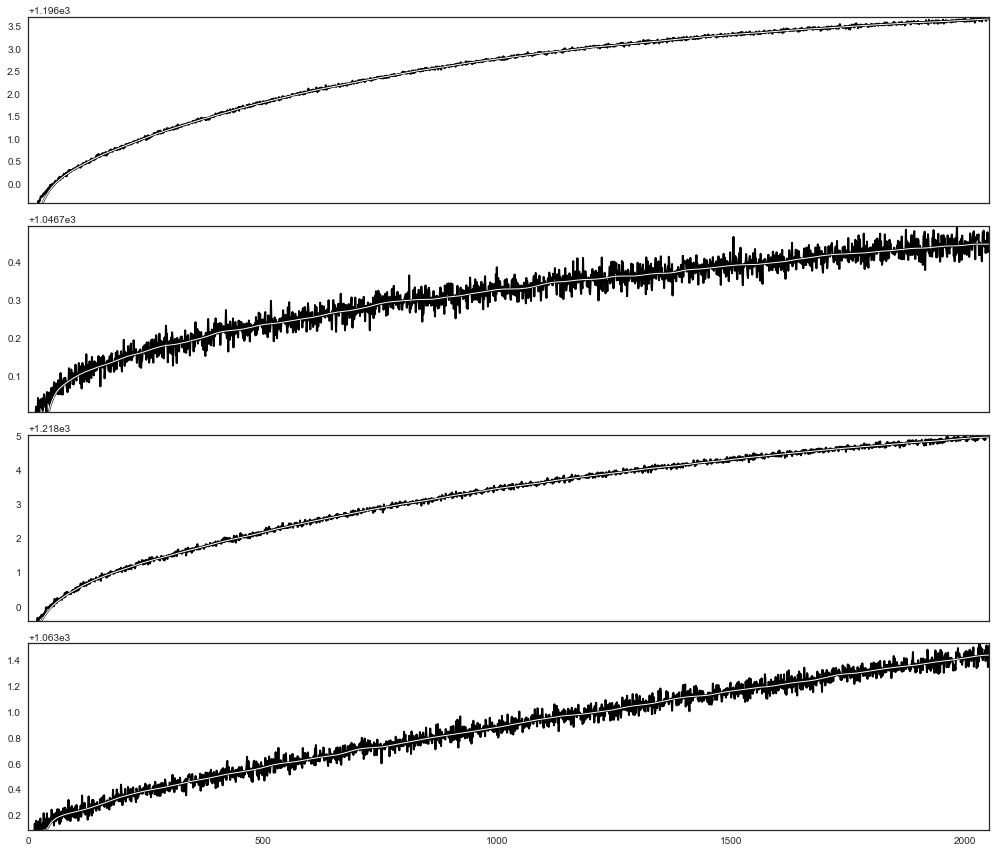

In [141]:
fig,axs = subplots(4,1,figsize=(14,12), sharex=True)
for i,k in enumerate(bkeys):
    axs[i].plot(b1d_raw[k], lw=2, c='k')
    axs[i].plot(b1d_denoised[k], lw=2, c='k')
    axs[i].plot(b1d_denoised[k], lw=1, c='w')
    axs[i].set_ylim(*percentile(b1d_raw[k], [1,100]))
setp(axs, xlim=(0,x.size))
fig.tight_layout()

In [164]:
df = pd.DataFrame((b1d_raw.values()+b1d_denoised.values())).T
df.index = pd.Series(arange(2051), name='Pixel')
df.to_hdf('results/calibration.h5','bias')

In [182]:
savez(join(dir_results,'bias_raw'), **b1d_raw)
savez(join(dir_results,'bias_denoised'), **b1d_denoised)

## Create the master flat
Variations in the pixel sensitivity across the CCD.

In [165]:
flats = dict(n1ccd1 = dstack([pf.getdata(flat,1) for flat in l_flat[0]]),
             n1ccd2 = dstack([pf.getdata(flat,2) for flat in l_flat[0]]),
             n2ccd1 = dstack([pf.getdata(flat,1) for flat in l_flat[1]]),
             n2ccd2 = dstack([pf.getdata(flat,2) for flat in l_flat[1]]))

In [166]:
masterflats = {k: f.mean(2) for k,f in flats.items()}

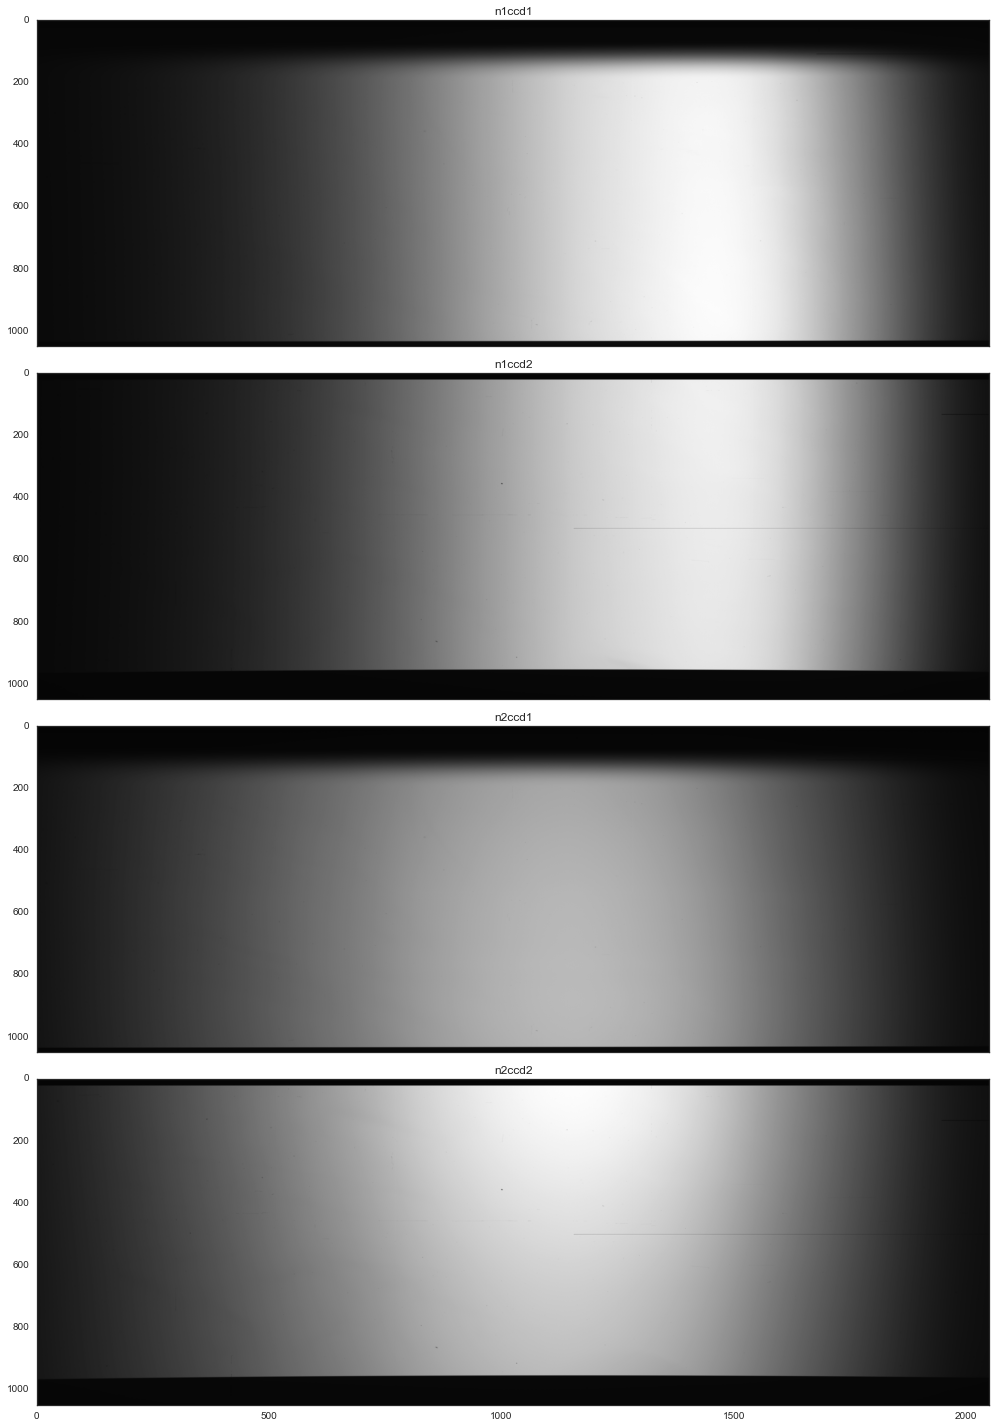

In [174]:
fig,ax = subplots(4,1,figsize=(14,20), sharex=True, sharey=True)
for i,k in enumerate(bkeys):
    ax.flat[i].imshow(masterflats[k].T, cmap=cm.gray, interpolation='bilinear', aspect='auto')
    ax.flat[i].set_title(k)
fig.tight_layout()

In [180]:
savez(join(dir_results,'masterflats'), **masterflats)